In [495]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Bidirectional
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import yfinance as yf
import tensorflow as tf
from pandas_datareader.yahoo.daily import YahooDailyReader
from stockstats import StockDataFrame
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler


# Define the list of stock tickers and the date range
stock_tickers = ['OXY']#, 'GOOGL', 'MSFT']  # Replace with your list of stock tickers
start_date = '1994-01-01'  # Replace with your desired start date
end_date = '2023-09-17'  # Replace with your desired end date
# end_date = datetime.today()

# Function to preprocess the data for LSTM model
def preprocess_data(stock_data):
    scaler = MinMaxScaler(feature_range=(0, 1))
    stock_data['scaled_close'] = scaler.fit_transform(stock_data['Close'].values.reshape(-1, 1))
    return stock_data


def preprocess_y(y):
    scaler = MinMaxScaler()
    reshaped_y = y.reshape(-1, 1)
    scaled_y = scaler.fit_transform(reshaped_y)
    # scaled_y = scaled.reshape(1, -1)
    print(scaled_y)
    return scaled_y

# Function to create sequences for training
def create_sequences(data, sequence_length, prediction_window):
    X = []
    y = []
    for i in range(len(data) - sequence_length - prediction_window + 1):
        X.append(data[i:i+sequence_length])
        future_price = data[i+sequence_length:i+sequence_length+prediction_window]
        current_price = data[i+sequence_length-1]
        price_change = future_price - current_price
        y.append(1 if np.any(price_change > 0) else 0)
    return np.array(X), np.array(y)

def create_time_steps(length):
    return list(range(-length, 0))

def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(18, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:, 0]), label='History')
    # if true_future.any():
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
        label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
                 label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()

def multinew_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []   

    # start_index = start_index + history_size
    start_index = -history_size
    if end_index is None:
        end_index = len(dataset) 

    for i in range(start_index, end_index-target_size):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

    return np.array(data)

def prediction_plot(history, prediction):
    plt.figure(figsize=(18, 6))
    num_in = create_time_steps(len(history))
    num_out = len(prediction[0])

    plt.plot(num_in, np.array(history), label='History')
    if prediction.any():
        # print(np.shape(np.arange(num_out)/STEP))
        # print(np.array(prediction)[0])
        plt.plot(np.arange(num_out)/STEP, np.array(prediction)[0], 'ro',
                 label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

In [496]:
# # Loop over each stock ticker
# # for ticker in stock_tickers:
# # Download stock price data using yfinance

[*********************100%%**********************]  1 of 1 completed


array([<Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>], dtype=object)

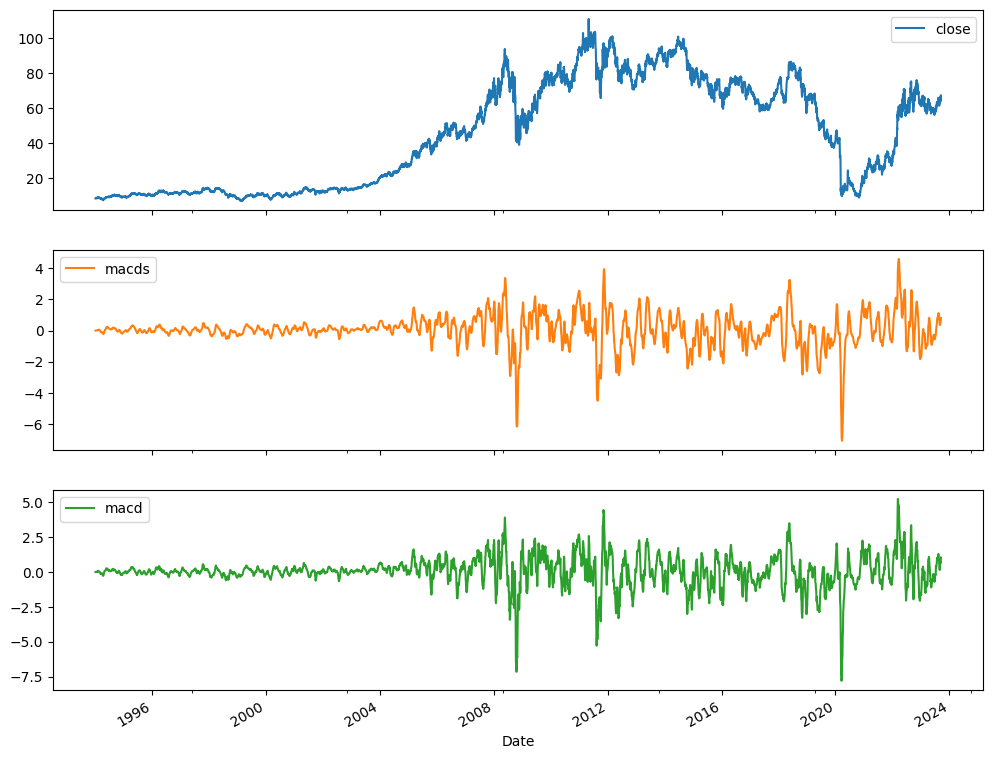

In [497]:
ticker = stock_tickers[0]

# df = YahooDailyReader(ticker, start='2018-01-01', end=datetime.now())
df = yf.download(ticker, start=start_date, end=end_date, auto_adjust=False)
df = StockDataFrame.retype(df)
df.head()

features_considered = ['close','macds','macd']
features = df[features_considered]
features.index = df.index
features.head()

features.plot(subplots=True,figsize=[12,10])

In [498]:
# Assuming your dataframe is called 'df' with columns 'column1', 'column2', 'column3'
columns_to_normalize = ['close', 'macds', 'macd']

# Create an instance of MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler on the selected columns
scaler.fit(features[columns_to_normalize])

# Transform the selected columns using the scaler
features[columns_to_normalize] = scaler.transform(features[columns_to_normalize])

dataset = features.values

dataset

array([[0.01268859, 0.60572289, 0.59795592],
       [0.01211185, 0.60565896, 0.59785295],
       [0.01384211, 0.60582061, 0.5982517 ],
       ...,
       [0.57073886, 0.66296861, 0.66635146],
       [0.58017828, 0.6691967 , 0.67705564],
       [0.56910144, 0.67428046, 0.67750889]])

In [693]:
past_history = 30
future_target = 5
STEP = 1


x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 0], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 0],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)


train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

2023-09-23 03:13:47.454091: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are 


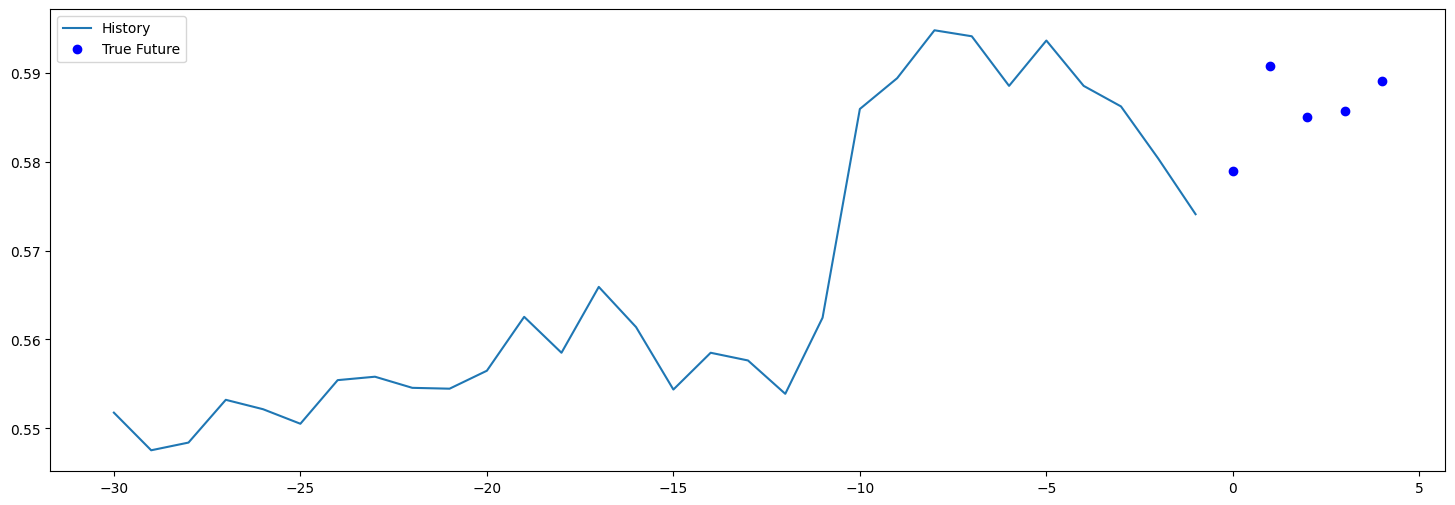

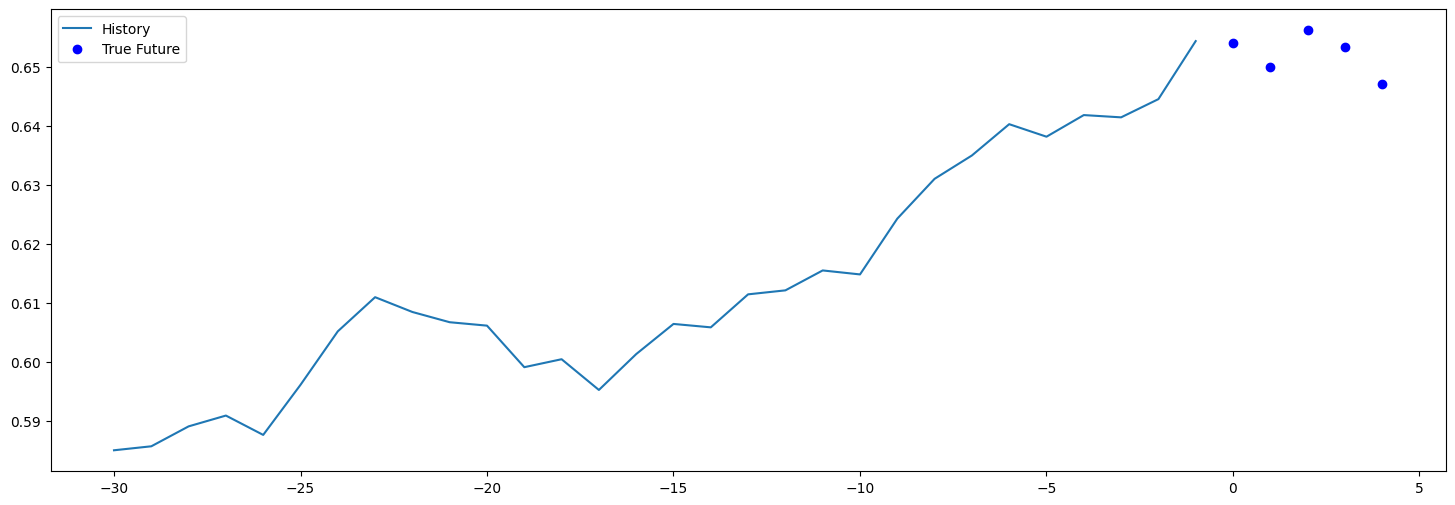

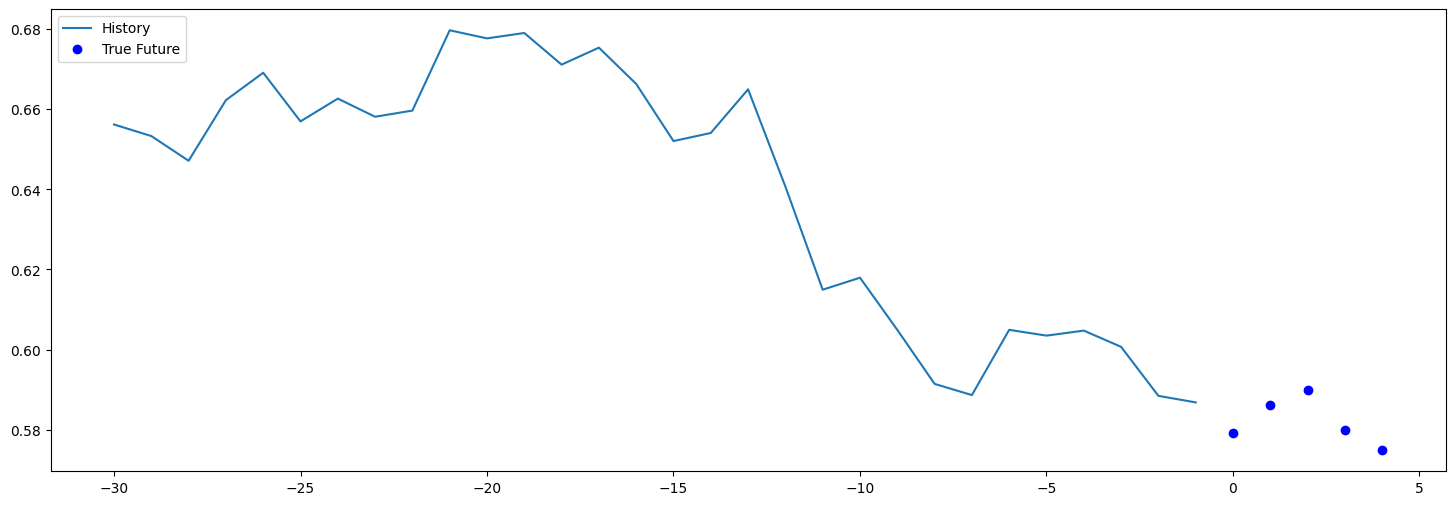

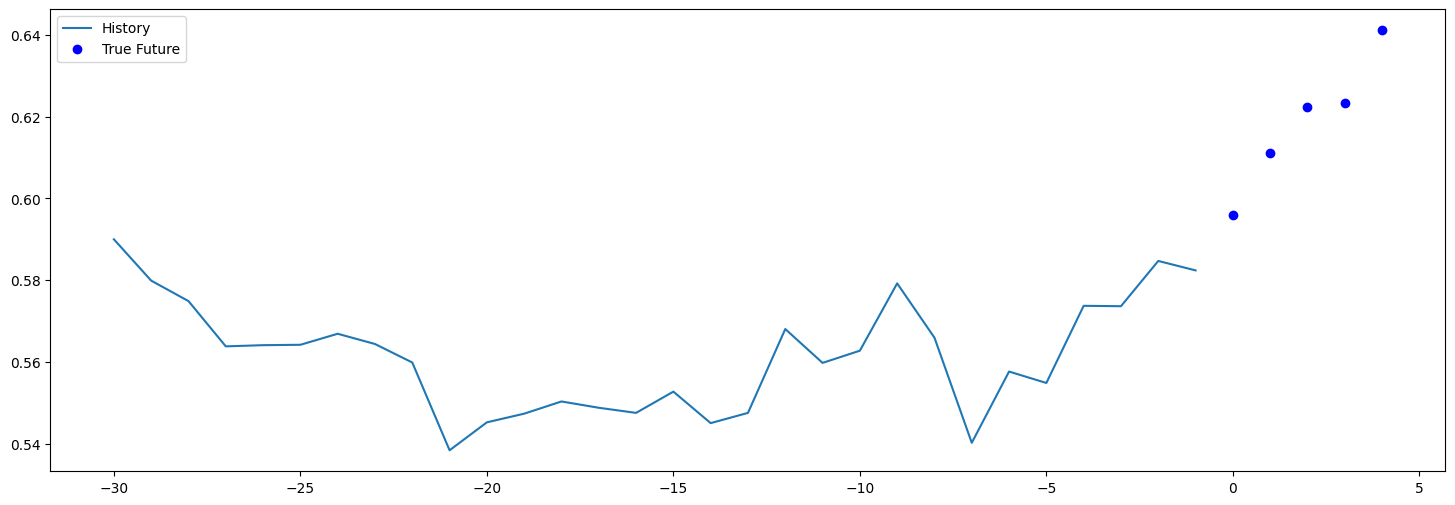

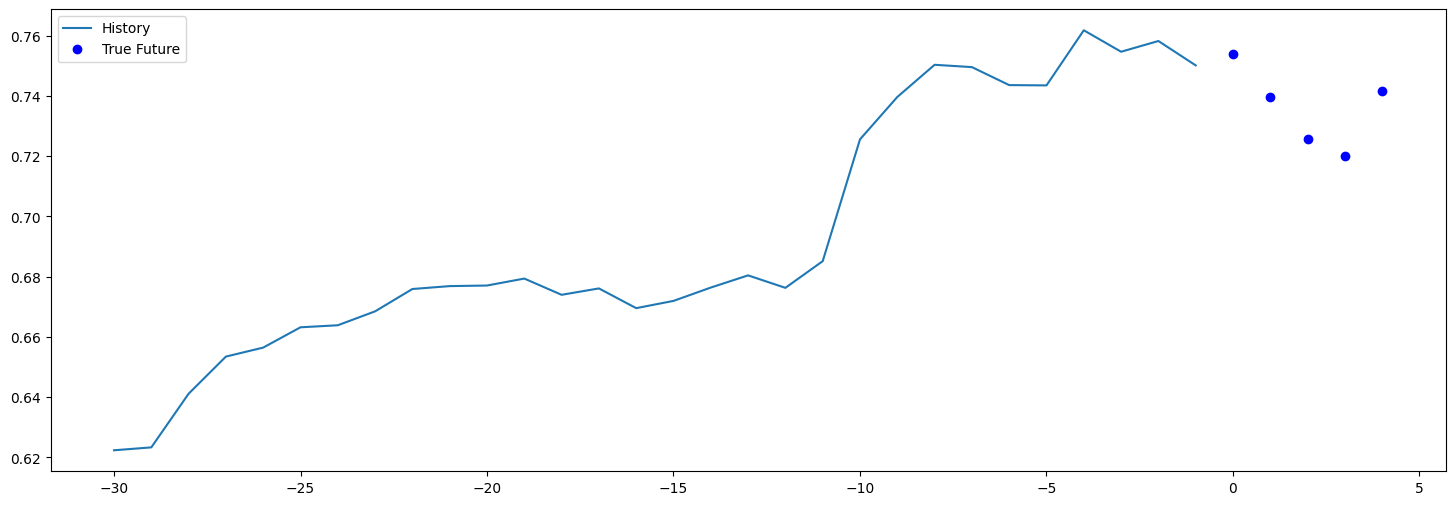

In [671]:
for x, y in val_data_multi.take(5):
    multi_step_plot(x[0], y[0], np.array([0]))

In [685]:
# Hyperparameters
BATCH_SIZE = 32
BUFFER_SIZE = 10000
TRAIN_SPLIT = int(df.shape[0] * 0.8)

# LSTM Parameters
EVALUATION_INTERVAL = 30#len(x_train_multi)//batch_size//2 #15
VALIDATION_INTERVAL = 30#len(x_val_multi)//batch_size//2
EPOCHS = 50
PATIENCE = 5

# Reproducibility
SEED = 42
tf.random.set_seed(SEED)

In [696]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(64,
                                        #   return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.Dropout(0.3))
multi_step_model.add(Dense(16))

# multi_step_model.add(tf.keras.layers.LSTM(32))
# multi_step_model.add(tf.keras.layers.Dropout(0.3))
# multi_step_model.add(Dense(16))

multi_step_model.add(Dense(future_target,activation='linear'))



multi_step_model.compile(optimizer=tf.keras.optimizers.legacy.Adam(),loss='mae', metrics='accuracy')
print(multi_step_model.summary())

Model: "sequential_89"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_180 (LSTM)             (None, 64)                17408     
                                                                 
 dropout_147 (Dropout)       (None, 64)                0         
                                                                 
 dense_225 (Dense)           (None, 16)                1040      
                                                                 
 dense_226 (Dense)           (None, 5)                 85        
                                                                 
Total params: 18533 (72.39 KB)
Trainable params: 18533 (72.39 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [697]:
early_stopping = EarlyStopping(monitor='val_loss', patience = 5, restore_best_weights=True)
multi_step_history = multi_step_model.fit(train_data_multi,
                                          epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=VALIDATION_INTERVAL,
                                          callbacks=[early_stopping])

Epoch 1/50
30/30 [==============================] - ETA: 0s - loss: 0.1841 - accuracy: 0.1885

2023-09-23 03:28:52.000134: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are 


30/30 [==============================] - 11s 118ms/step - loss: 0.1841 - accuracy: 0.1885 - val_loss: 0.0501 - val_accuracy: 0.1677
Epoch 2/50
30/30 [==============================] - 2s 56ms/step - loss: 0.0715 - accuracy: 0.1885 - val_loss: 0.0246 - val_accuracy: 0.1469
Epoch 3/50
30/30 [==============================] - 2s 50ms/step - loss: 0.0569 - accuracy: 0.2062 - val_loss: 0.0309 - val_accuracy: 0.1625
Epoch 4/50
30/30 [==============================] - 1s 50ms/step - loss: 0.0517 - accuracy: 0.1990 - val_loss: 0.0220 - val_accuracy: 0.2042
Epoch 5/50
30/30 [==============================] - 1s 50ms/step - loss: 0.0460 - accuracy: 0.2146 - val_loss: 0.0230 - val_accuracy: 0.1708
Epoch 6/50
30/30 [==============================] - 1s 49ms/step - loss: 0.0425 - accuracy: 0.1948 - val_loss: 0.0210 - val_accuracy: 0.2052
Epoch 7/50
30/30 [==============================] - 1s 49ms/step - loss: 0.0407 - accuracy: 0.1937 - val_loss: 0.0202 - val_accuracy: 0.2219
Epoch 8/50
30/30 [====

In [ ]:
# plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

<Axes: title={'center': 'Accuracy'}>

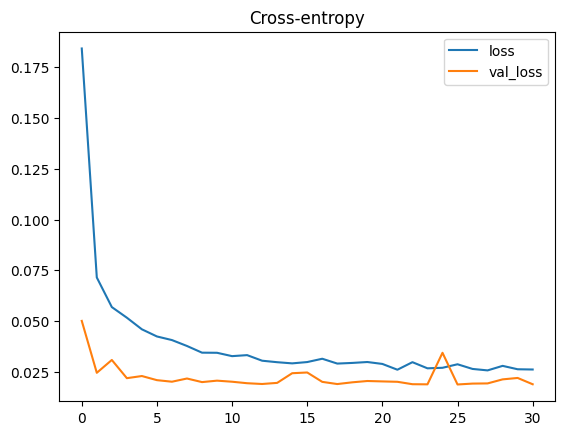

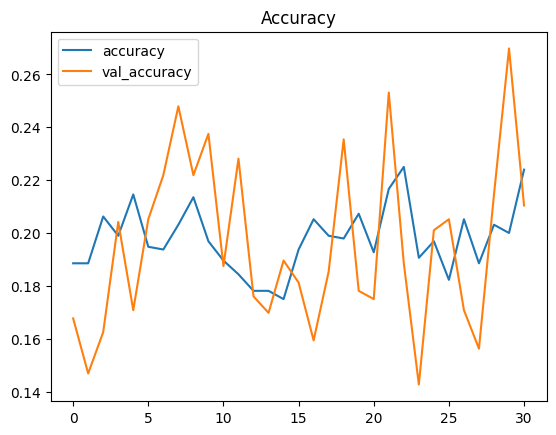

In [698]:
history_df = pd.DataFrame(multi_step_history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['accuracy', 'val_accuracy']].plot(title="Accuracy")

2023-09-23 03:29:56.130429: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are 
2023-09-23 03:29:56.452350: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are distribute_options {
  auto_shard_policy: DATA
}
optimization_options {
  apply_default_optimizations: false
}
threading_options {
}
autotune_options {
}
warm_start: false



1/1 [==============================] - 3s 3s/step


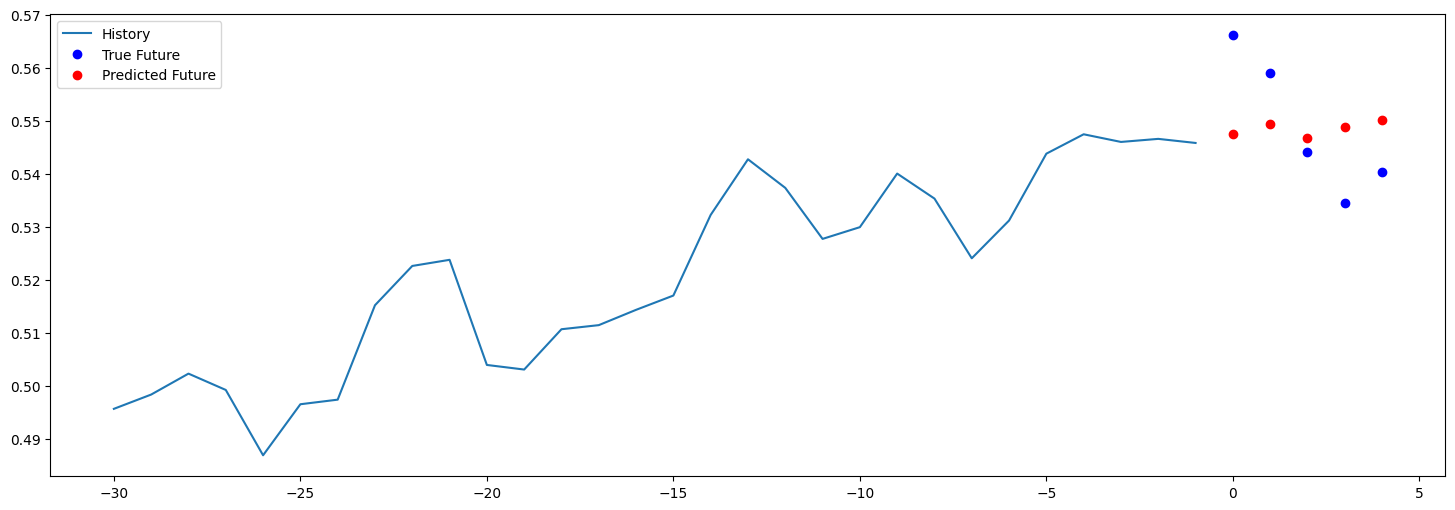

In [699]:
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 0],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

x_val_multi = x_val_multi[-20:]
y_val_multi = y_val_multi[-20:]

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))

val_data_multi = val_data_multi.batch(BATCH_SIZE)#.repeat()

for x, y in val_data_multi.take(5):
    multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])


In [703]:
x_new_multi = multinew_data(dataset, dataset[:, 0],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

x_new_multi = x_new_multi[-20:]


predictions_0 = multi_step_model.predict(x_new_multi[0:1])
predictions_1 = multi_step_model.predict(x_new_multi[-1:])#[0]
    

predictions_0, predictions_1
# np.shape(x_new_multi)

1/1 [==============================] - 0s 121ms/step


2023-09-23 03:30:35.155594: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are distribute_options {
  auto_shard_policy: DATA
}
optimization_options {
  apply_default_optimizations: false
}
threading_options {
}
autotune_options {
}
warm_start: false



1/1 [==============================] - 0s 64ms/step


2023-09-23 03:30:35.480607: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are distribute_options {
  auto_shard_policy: DATA
}
optimization_options {
  apply_default_optimizations: false
}
threading_options {
}
autotune_options {
}
warm_start: false



(array([[0.5475262 , 0.54944867, 0.5466926 , 0.5487775 , 0.55018634]],
       dtype=float32),
 array([[0.55845875, 0.5605997 , 0.55825186, 0.55914193, 0.5629071 ]],
       dtype=float32))

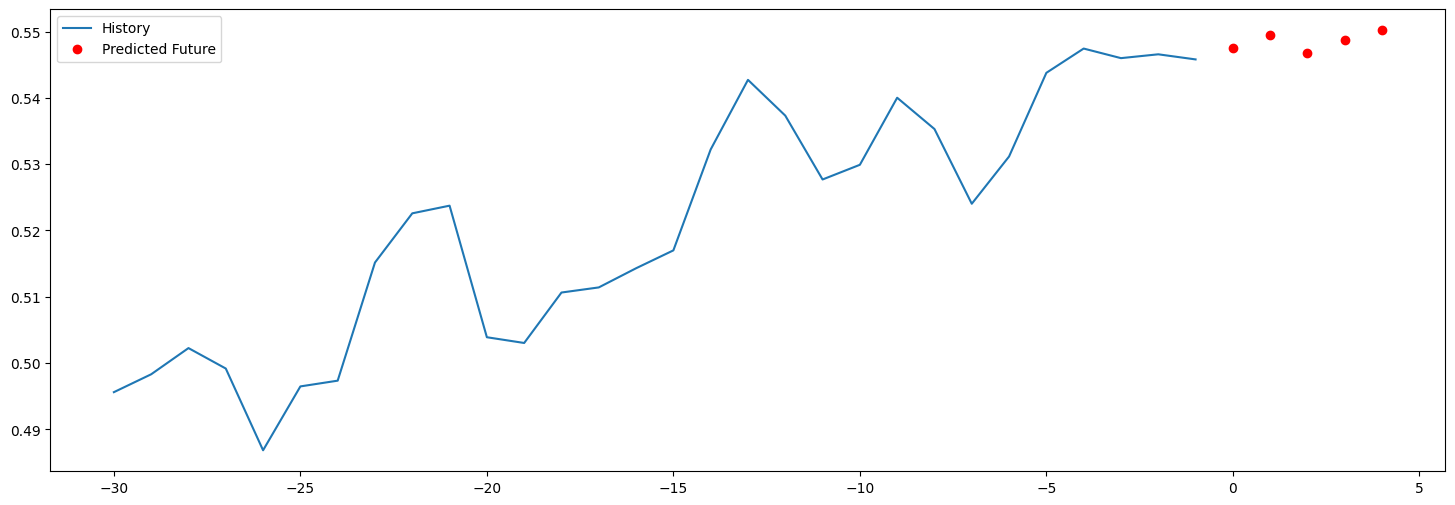

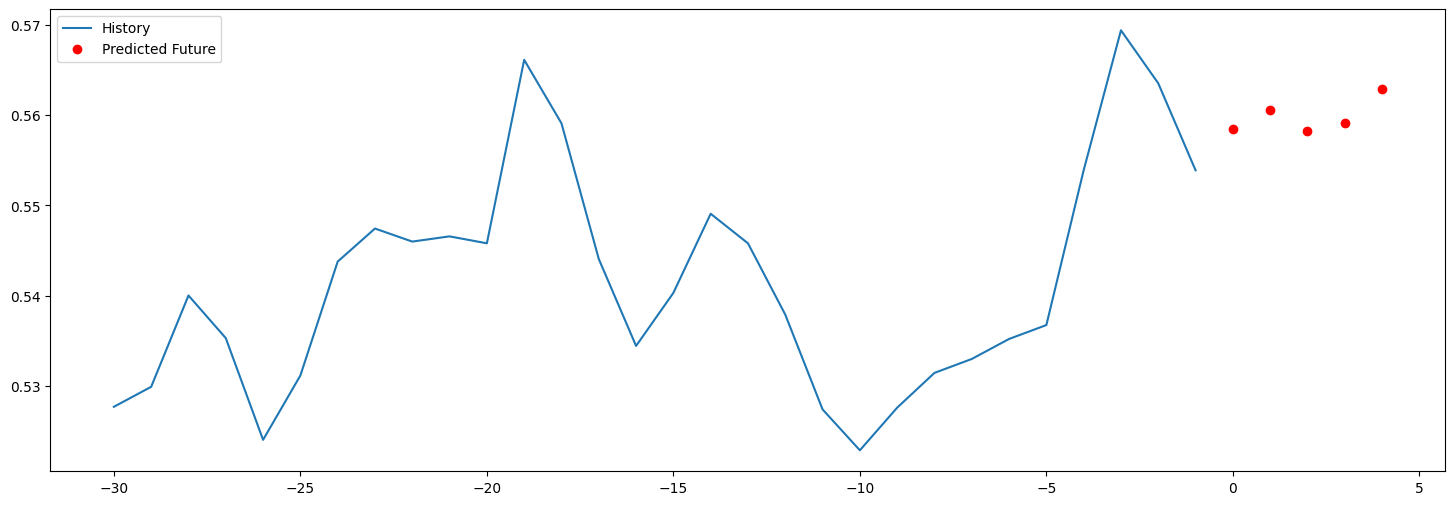

In [701]:
# New Predictions
prediction_plot(x_new_multi[0][:,0], predictions_0)
prediction_plot(x_new_multi[-1][:,0], predictions_1)

In [ ]:
#  multi_step_model.save(f"model/model_{ticker}.h5")